In [1]:
%load_ext autoreload
%autoreload 2

import jax
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from diffbank.noise import Sn_aLIGO as Sn
from diffbank.utils import _get_effectualness

from pycbc.types import FrequencySeries
from pycbc.filter.matchedfilter import match

## 3PN

In [2]:
from diffbank.waveforms.threePN_simple import amp, Psi

In [3]:
key = random.PRNGKey(1)

# Frequency grid
df = 0.0125
f_low = 8.0
f_high = 512.0
n_f = int((f_high - f_low) / df) + 1
fs = jnp.linspace(f_low, f_high, n_f)

# Padding
df = fs[1] - fs[0]
N = 2 * jnp.array(fs[-1] / df - 1).astype(int)
_eff_pad_low = jnp.zeros(jnp.array(fs[0] / df).astype(int))
_eff_pad_high = jnp.zeros(N - jnp.array(fs[-1] / df).astype(int))

eff_fn = jax.jit(
    lambda theta1, theta2: _get_effectualness(
        theta1, theta2, amp, Psi, fs, Sn, _eff_pad_low, _eff_pad_high
    )
)

match_dbs = []
match_pycbcs = []

for _ in range(20):
    # Set parameters
    key, M1_key, M2_key, eta1_key, eta2_key = random.split(key, 5)
    M1 = random.uniform(M1_key, minval=2.0, maxval=10.0)
    M2 = random.uniform(M2_key, minval=M1 - 0.0001, maxval=M1 + 0.0001)
    eta1 = random.uniform(eta1_key, minval=0.2, maxval=0.25)
    eta2 = random.uniform(
        eta2_key, minval=eta1 - 0.0005, maxval=min(0.25, eta1 + 0.0005)
    )
    theta1 = jnp.array([M1, eta1])
    theta2 = jnp.array([M2, eta2])

    # diffbank
    match_db = eff_fn(theta1, theta2)
    match_dbs.append(match_db)

    # pycbc
    n_f_pycbc = int(f_high / df) + 1
    fs_pycbc = jnp.linspace(0, f_high, n_f_pycbc)
    psd_pycbc = FrequencySeries(Sn(fs_pycbc), df)
    wf1_pycbc = FrequencySeries(
        amp(fs_pycbc, theta1) * jnp.exp(1j * Psi(fs_pycbc, theta1)), df
    )
    wf2_pycbc = FrequencySeries(
        amp(fs_pycbc, theta2) * jnp.exp(1j * Psi(fs_pycbc, theta2)), df
    )
    match_pycbc = match(wf1_pycbc, wf2_pycbc, psd_pycbc, f_low, f_high)[0]
    match_pycbcs.append(match_pycbc)

    print(f"{match_db:.5f}, {match_pycbc:.5f}")

match_dbs = jnp.array(match_dbs)
match_pycbcs = jnp.array(match_pycbcs)

0.92063, 0.92059
0.86875, 0.86872
0.99789, 0.99789
0.99079, 0.99079
0.54263, 0.54262
0.63344, 0.63343
0.74638, 0.74638
0.79206, 0.79206
0.78729, 0.78729
0.61130, 0.61131
0.74556, 0.74557
0.63941, 0.63940
0.99808, 0.99808
0.65572, 0.65569
0.72981, 0.72978
0.99330, 0.99330
0.99913, 0.99913
0.88382, 0.88378
0.87647, 0.87643
0.69336, 0.69333


Compare matches

Text(0.5, 1.0, '3PN')

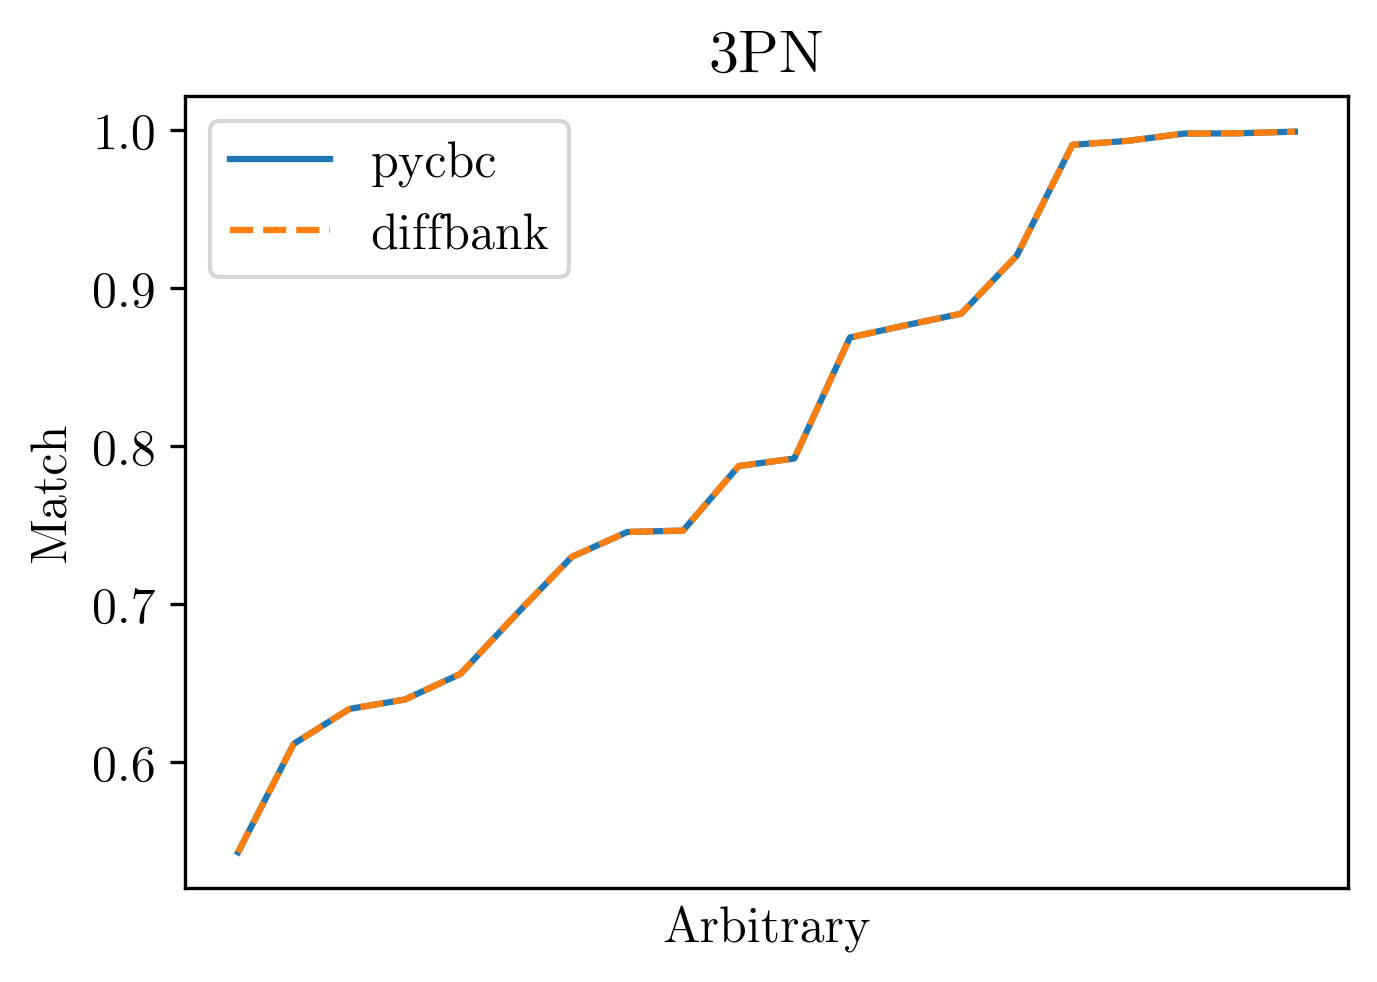

In [4]:
idxs = jnp.argsort(match_pycbcs)

plt.plot(match_pycbcs[idxs], label="pycbc")
plt.plot(match_dbs[idxs], "--", label="diffbank")

plt.xticks([])
plt.xlabel("Arbitrary")
plt.ylabel("Match")
plt.legend()
plt.title("3PN")

## $\kappa$

In [5]:
from diffbank.waveforms.kappa4D import Amp as amp, Psi

In [6]:
key = random.PRNGKey(9)

# Frequency grid
df = 0.0125
f_low = 8.0
f_high = 512.0
n_f = int((f_high - f_low) / df) + 1
fs = jnp.linspace(f_low, f_high, n_f)

# Padding
df = fs[1] - fs[0]
N = 2 * jnp.array(fs[-1] / df - 1).astype(int)
_eff_pad_low = jnp.zeros(jnp.array(fs[0] / df).astype(int))
_eff_pad_high = jnp.zeros(N - jnp.array(fs[-1] / df).astype(int))

eff_fn = jax.jit(
    lambda theta1, theta2: _get_effectualness(
        theta1, theta2, amp, Psi, fs, Sn, _eff_pad_low, _eff_pad_high
    )
)

# Param ranges
m1_range = (1.001, 5.0)
m2_range = (1.0, 5.0)
chiz_range = (-0.6, 0.6)
kappa2PN_range = (0.0, 250.0)

match_dbs = []
match_pycbcs = []

for _ in range(14):
    # Set parameters
    key, m1_key, m2_key, chiz_key, kappa2PN_key, theta2_key = random.split(key, 6)
    m1 = random.uniform(m1_key, minval=m1_range[0], maxval=m1_range[1])
    m2 = random.uniform(m2_key, minval=m2_range[0], maxval=m2_range[1])
    chiz = random.uniform(chiz_key, minval=chiz_range[0], maxval=chiz_range[1])
    kappa2PN = random.uniform(
        kappa2PN_key, minval=kappa2PN_range[0], maxval=kappa2PN_range[1]
    )
    theta1 = jnp.array([m1, m2, chiz, kappa2PN])
    theta2 = theta1 + random.normal(theta2_key, theta1.shape) * 0.0012

    # diffbank
    match_db = eff_fn(theta1, theta2)
    match_dbs.append(match_db)

    # pycbc
    n_f_pycbc = int(f_high / df) + 1
    fs_pycbc = jnp.linspace(0, f_high, n_f_pycbc)
    psd_pycbc = FrequencySeries(Sn(fs_pycbc), df)
    wf1_pycbc = FrequencySeries(
        amp(fs_pycbc, theta1) * jnp.exp(1j * Psi(fs_pycbc, theta1)), df
    )
    wf2_pycbc = FrequencySeries(
        amp(fs_pycbc, theta2) * jnp.exp(1j * Psi(fs_pycbc, theta2)), df
    )
    match_pycbc = match(wf1_pycbc, wf2_pycbc, psd_pycbc, f_low, f_high)[0]
    match_pycbcs.append(match_pycbc)

    print(f"{match_db:.5f}, {match_pycbc:.5f}")

match_dbs = jnp.array(match_dbs)
match_pycbcs = jnp.array(match_pycbcs)

0.93234, 0.93234
0.99994, 0.99994
0.97586, 0.97586
0.99450, 0.99449
0.99816, 0.99816
0.98762, 0.98762
0.99879, 0.99878
0.98111, 0.98111
0.93195, 0.93195
0.99533, 0.99533
0.97444, 0.97444
0.96742, 0.96742
0.97289, 0.97288
0.97464, 0.97462


Compare matches

Text(0.5, 1.0, '4D $\\kappa$')

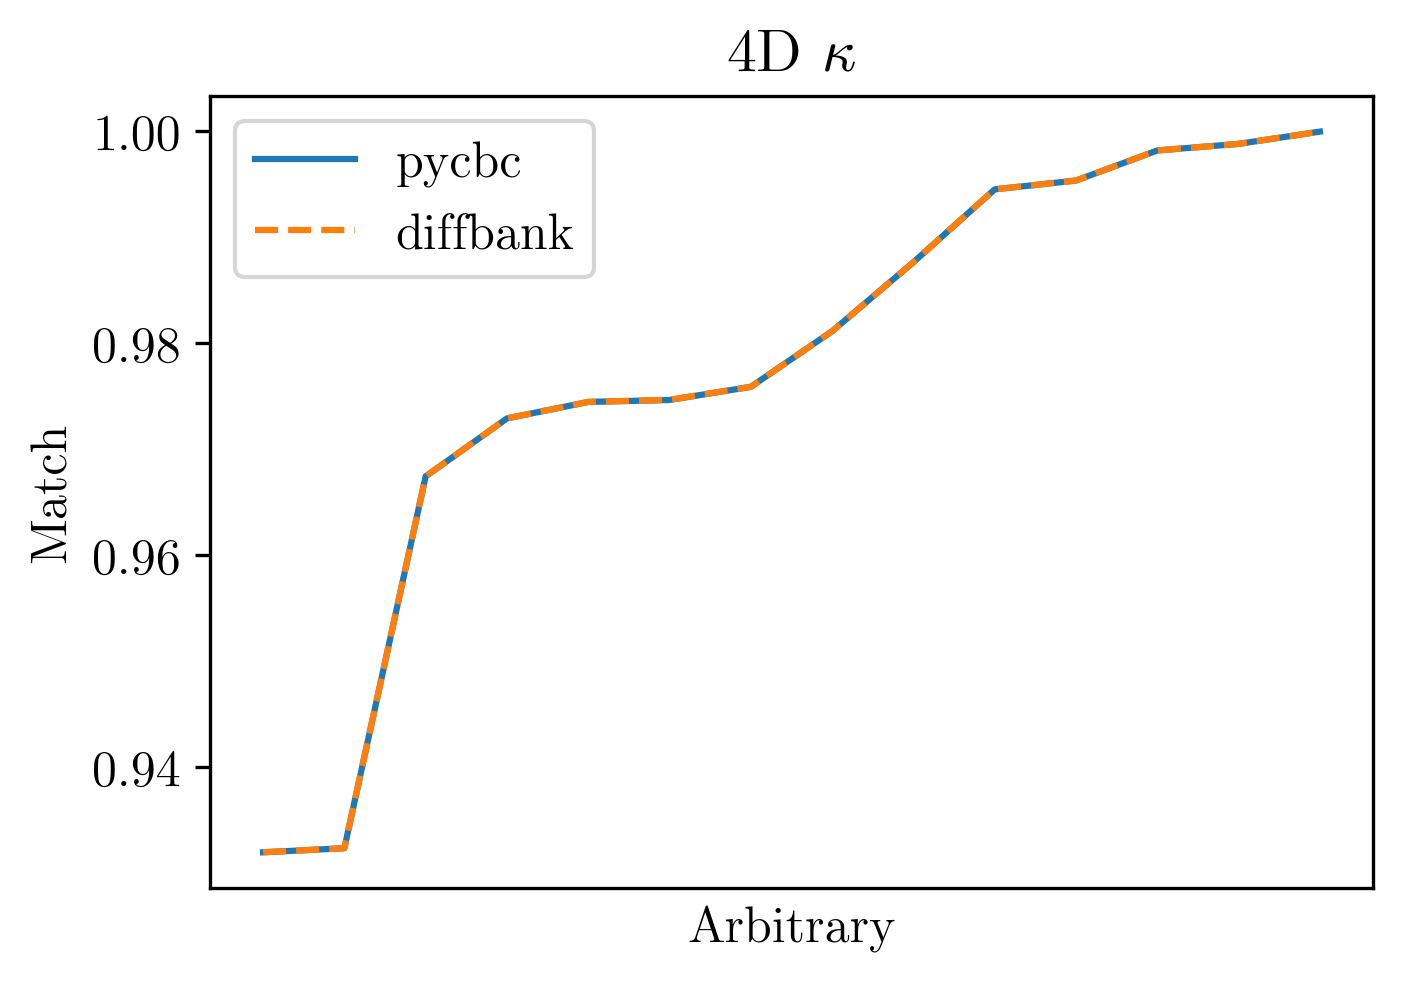

In [7]:
idxs = jnp.argsort(match_pycbcs)

plt.plot(match_pycbcs[idxs], label="pycbc")
plt.plot(match_dbs[idxs], "--", label="diffbank")

plt.xticks([])
plt.xlabel("Arbitrary")
plt.ylabel("Match")
plt.legend()
plt.title(r"4D $\kappa$")